In [2]:
#import nest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import elephant
import quantities as pq
import neo
import sys
from scipy.stats import ks_2samp
plt.rcParams['figure.figsize'] = (14, 10)
import scipy.stats as stats
import itertools
import random
# If seaborn and elephant not available, run the sommands:
# !{sys.executable} -m pip install elephant
# !{sys.executable} -m pip install seaborn

# CV


In this file we will look at the CV of 10 different simulations in 5 different versions of brunel. We have the following models:

- Brunel with rounded spiketimes and discrete delays from interval [1.0, 2.0]
- Brunel with exact spiketimes and discrete delays from interval [1.0, 2.0]
- Brunel with rounded spiketimes and discrete delays from interval [0.9375, 2.0625]
- Brunel with exact spiketimes and discrete delays from interval [0.9375, 2.0625]
- Brunel with exact spiketimes and continuous delays from interval [1.0, 2.0]

Note that when the model uses discrete delays in interval [1.0, 2.0] the end points only have half the probability of getting drawn. When the discrete values are drawn from interval [0.9375, 2.0625], all points have equal probability of getting drawn. This because we use resolution 1/8. We use the continuous delay brunel model as the reference model, "true values". All simulations are run for 10s. Within one model, there are 10 simulations, each having a different seed value.

In this document we look at the distribution of the CVs for each simulation. We start by looking at the CV distribution for the 10 simulations in the same model. Run a Kolmogorov-Smirnov test on each possible pair of simulations, make sure that the KS-test gives us a pass, the CV distributions are supposed to be from the same distribution. Check that the p-values are uniformly distributed between 0 and 1. In that case there is not much difference.



We tried running a KS test on all possible pairs of simulations from the same model. But surprisingly the p-values where far from uniformly distributed, and many of the tests failed. This is because we calculate the CV value for each neuron in the network and then look at the distribtuion of the CVs. But since the cv of a neuron is depepndent on the spiking activity of other neurons in the network, the samples are not independent. A possible solution could be to run the ks-test on N randomly drawn samples from each distribution. We try this for N=500. Tried for some of the models, but while it was better for the first model, the others got more failed tests. Need to fix this problem some other way.


Code for retrieving CV distribution of single simulation:

In [56]:
def get_cvs(spike_data):
    """
    Get the CV for each neuron recorded. 
    
    CV = standard_deviation(ISIs)/mean(ISIs)
    """
    cvs = []
     
    spike_data = spike_data.sort_values(by='time_ms')
    grouped = spike_data.groupby(spike_data['sender'])

    for name, group in grouped:
            """
            Each group is senders and times for one value of senders. That is, we iterate through all 
            neurons. And the times for each neuron is in sorted order. Therefore, the cvs
            returned must have the same order. So cvs contain cv of neuron 1, then neuron 2 .... then neuron N.
            """
            t = np.asarray(group['time_ms'])
            spiketrain = neo.core.SpikeTrain(t * pq.ms, t_start=0*pq.ms, t_stop=10000*pq.ms)
            isi = elephant.statistics.isi(spiketrain)
            cv = elephant.statistics.cv(isi)
            cvs.append(cv)
            
    return cvs

Function for retrieving cv distributions of excitatory and inhibitory population.

In [57]:
def get_cv_lists(exc, inh):
    cv_list_exc = list()
    for i in range(1,11):
        exc_cvs = get_cvs(exc[i])
        cv_list_exc.append(exc_cvs)

    cv_list_inh = list()
    for i in range(1,11):
        inh_cvs = get_cvs(inh[i])
        cv_list_inh.append(inh_cvs)
    return cv_list_exc, cv_list_inh

Functions for retrieving spike data from the 5 different brunel models.

In [5]:
def round_1_2():
    """
    Get spike data from brunel model with rounded spike times and delays drawn from discrete interval [1.0, 2.0].
    """
    #spike_path = '/opt/data/spike_data/brunel_10s/brunel_rounding_1_2'
    spike_path='C:\\Users\\Nida\\Documents\\NMBU\\master\\spike_data\\brunel_10s\\resolution_1_8\\brunel_rounding_1_2'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_1.0_2.0_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_1.0_2.0_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    return exc, inh

In [59]:
def exact_1_2():
    """
    Get spike data from brunel model with exact spike times and delays drawn form discrete interval [1.0, 2.0].
    """
    spike_path = '/opt/data/spike_data/brunel_10s/brunel_exact_1_2'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_1.0_2.0_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_1.0_2.0_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    return exc, inh

In [60]:
def round_equal():
    """
    Get spike data from brunel model with rounded spikes times and delay form interval [0.9375, 2.0625].
    """
    spike_path = '/opt/data/spike_data/brunel_10s/brunel_rounding_0_9375_2_0625'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_0.9375_2.0625_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_0.9375_2.0625_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
        
    return exc, inh

In [61]:
def exact_equal():
    """
    Get spike data from brunel with exact spike times and delays drawn from interval [0.9375, 2.0625].
    """
    
    spike_path = '/opt/data/spike_data/brunel_10s/brunel_exact_0_9375_2_0625'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_0.9375_2.0625_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_0.9375_2.0625_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    
    return exc, inh

In [62]:
def continuous():
    """
    Get spike data from brunel model with delay drawn from continuous interval [1.0, 2.0].
    """
    spike_path = '/opt/data/spike_data/brunel_10s/brunel_continuous'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_continuous_delay_1.0_2.0_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_continuous_delay_1.0_2.0_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    return exc, inh

Function for running KS-test on all possible pairs of simulations from the same model.

In [63]:
def ks_test(value_list):
    """
    Perform KS-test on all possible pairs of simulations from same model. (10 simulations). 
    Return statistic and p-values.
    """
    statistics = []
    p_values = []
    for i in range(0,10):
        for j in range(0,i):
            statistic = ks_2samp(value_list[i], value_list[j], alternative='two-sided')[0]
            p_value = ks_2samp(value_list[i], value_list[j], alternative='two-sided')[1]
            p_values.append(p_value)
            statistics.append(statistic)
    return statistics, p_values
        

Function for finding number of tests which passed and which failed.

In [68]:
def num_fail_pass(p_values, significance_level = 0.01):
    """
    Get number of tests which failed and which passed.
    """
    failed = 0
    passed = 0
    for i in range(0,len(statistics)):
        if p_values[i] < significance_level:
            # test fails
            failed += 1
        else:
            passed += 1
    s = str(passed) + ' tests passed, ' + str(failed) + ' tests failed.'
    return s

## Brunel with rounded spike times and discrete delays in interval [1.0, 2.0]

First we retrieve the spike data for all the simulations of both excitatory and inhibitory neurons:

In [6]:
exc, inh = round_1_2()

In [14]:
max(exc[1]['sender'])

10000

We now retrieve the CV distribution of each simualtion, for both excitatory and inhibitory neurons.

In [66]:
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)

### Pair-wise KS-test on excitatory neurons CV distribution

The KS statistic gives the maximum value difference between two empirical cumulative distributions. So the smaller the statistic, the more similar is the distributions. The null hypothesis is that the two distributions are equal. The test accept the null-hypothesis if the statistic is smaller than the p-value.

We run a KS test on each possible pair of excitatory neurons CV distribution.

In [69]:
statistics, p_values = ks_test(cv_list_exc)
s = num_fail_pass(p_values)
print(s)

34 tests passed, 11 tests failed.


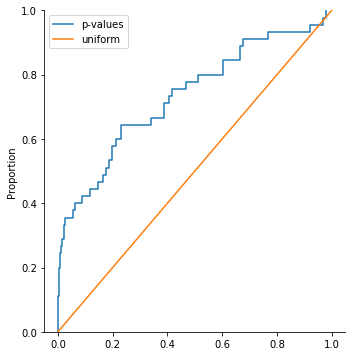

In [70]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()



### Pair-wise KS-test on inhibitory neurons CV distribution

In [71]:
statistics, p_values = ks_test(cv_list_inh)
s = num_fail_pass(p_values)
print(s)

43 tests passed, 2 tests failed.


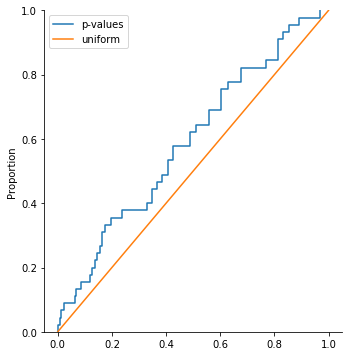

In [72]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

The inhibitory neurons seem to be more consistent as their p-values are closer to the uniform distribution.

## Brunel with exact spike times and discrete delays in interval [1.0, 2.0]

In [73]:
exc, inh = exact_1_2()
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)

### Pair-wise KS-test on excitatory neurons CV distribution

In [74]:
statistics, p_values = ks_test(cv_list_exc)
s = num_fail_pass(p_values)
print(s)

44 tests passed, 1 tests failed.


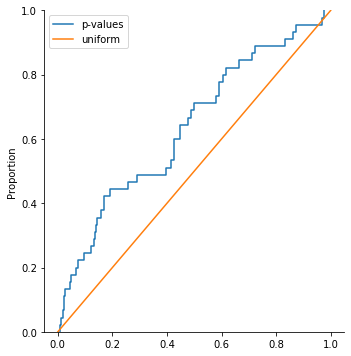

In [75]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

More consistent than excitatory neurons with rounded spike times on [1.0, 2.0].

### Pair-wise KS-test on inhibitory neurons CV distribution

In [76]:
statistics, p_values = ks_test(cv_list_inh)
s = num_fail_pass(p_values)
print(s)

44 tests passed, 1 tests failed.


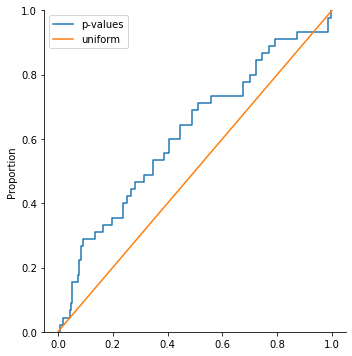

In [77]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

## Brunel with rounded spike times and discrete delays in interval [0.9375, 2.0625]

In [78]:
exc, inh = round_equal()
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)

### Pairwise KS-test on excitatory neurons

In [79]:
statistics, p_values = ks_test(cv_list_exc)
s = num_fail_pass(p_values)
print(s)

28 tests passed, 17 tests failed.


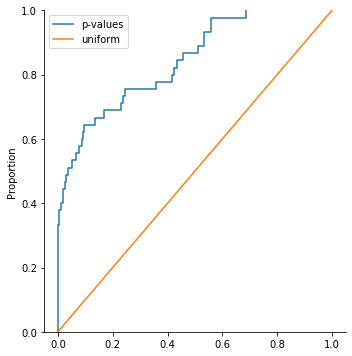

In [80]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Pairwise KS-test on inhibitory neurons

In [81]:
statistics, p_values = ks_test(cv_list_inh)
s = num_fail_pass(p_values)
print(s)

42 tests passed, 3 tests failed.


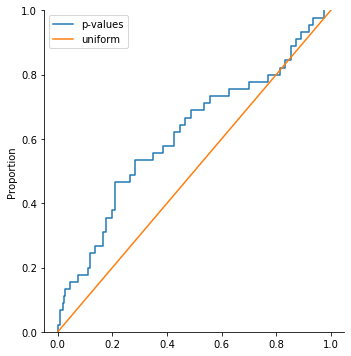

In [82]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

## Brunel with exact spike times and discrete delays in interval [0.9375, 2.0625]

In [83]:
exc, inh = exact_equal()
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)

### Pairwise KS-test on excitatory neurons

In [84]:
statistics, p_values = ks_test(cv_list_exc)
s = num_fail_pass(p_values)
print(s)

37 tests passed, 8 tests failed.


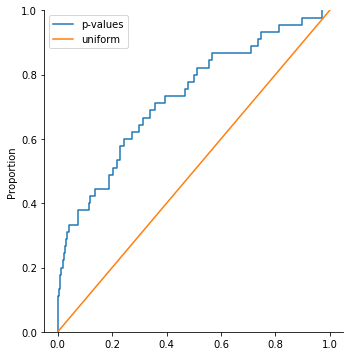

In [85]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Pairwise KS-test on inhibitory neurons

In [87]:
statistics, p_values = ks_test(cv_list_inh)
s = num_fail_pass(p_values)
print(s)

42 tests passed, 3 tests failed.


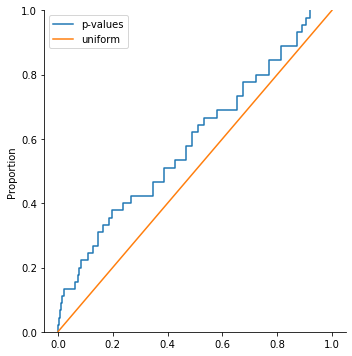

In [88]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

## Brunel with continuous delays [1.0, 2.0]

In [89]:
exc, inh = continuous()
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)

### Pairwise KS-test on excitatory neurons

In [90]:
statistics, p_values = ks_test(cv_list_exc)
s = num_fail_pass(p_values)
print(s)

25 tests passed, 20 tests failed.


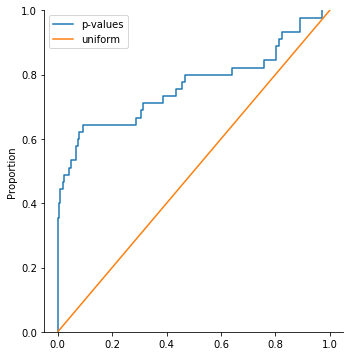

In [91]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Pairwise KS-test on inhibitory neurons

In [92]:
statistics, p_values = ks_test(cv_list_inh)
s = num_fail_pass(p_values)
print(s)

43 tests passed, 2 tests failed.


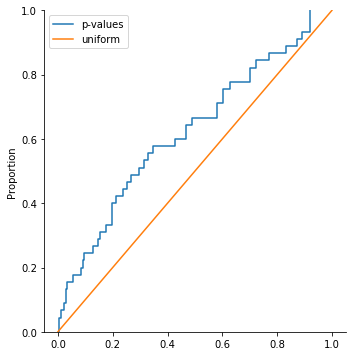

In [93]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

## Comparing models

We now start running the KS-tests on each possible pair of simulations from two different models. We want to get an overview over how similar the CV distribution is for two different models. All of the discrete cases should be compared  to the continuous case, but also against each other. We start with comparing the Brunel model with the rounded spike times and delays drawn from the discrete delay interval [1.0, 2.0].

In [94]:
def ks_test(value_list_1, value_list_2):
    """
    Perform KS-test on all possible compinations of pairwise simulations in two different models.
    """
    comb = list(itertools.product(value_list_1, value_list_2))

    statistics = []
    p_values = []
    for i in range(0,len(comb)):
        statistic = ks_2samp(comb[i][0],comb[i][1],alternative='two-sided')[0]
        p_value = ks_2samp(comb[i][0],comb[i][1],alternative='two-sided')[1]
        statistics.append(statistic)
        p_values.append(p_value)
    return statistics, p_values

### Rounded brunel on discrete [1.0, 2.0] vs. exact brunel on discrete [1.0, 2.0]

First we read in the data (make sure this part is independent of what was run earlier). 

In [95]:
exc_1, inh_1 = round_1_2()
exc_2, inh_2 = exact_1_2()

Get the CV distributions.

In [96]:
cv_list_exc_1, cv_list_inh_1 = get_cv_lists(exc_1, inh_1)
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [97]:
statistics, p_values = ks_test(cv_list_exc_1, cv_list_exc_2)
s = num_fail_pass(p_values)
print(s)

0 tests passed, 100 tests failed.


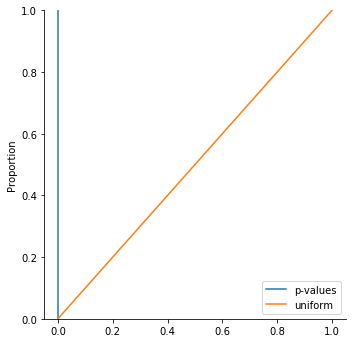

In [98]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [99]:
statistics, p_values = ks_test(cv_list_inh_1, cv_list_inh_2)
s = num_fail_pass(p_values)
print(s)

0 tests passed, 100 tests failed.


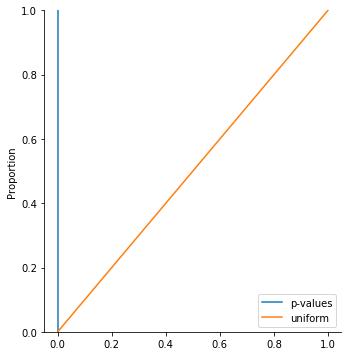

In [100]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Rounded brunel on [1.0, 2.0] vs. rounded brunel on [0.9375, 2.0625]

Get the data for the second model.

In [101]:
exc_2, inh_2 = round_equal()
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [102]:
statistics, p_values = ks_test(cv_list_exc_1, cv_list_exc_2)
s = num_fail_pass(p_values)
print(s)

71 tests passed, 29 tests failed.


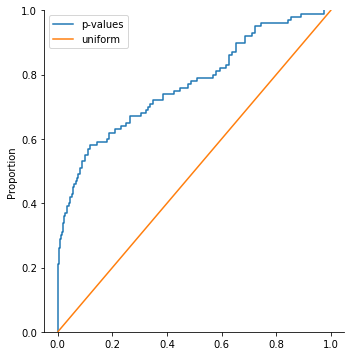

In [103]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [104]:
statistics, p_values = ks_test(cv_list_inh_1, cv_list_inh_2)
s = num_fail_pass(p_values)
print(s)

97 tests passed, 3 tests failed.


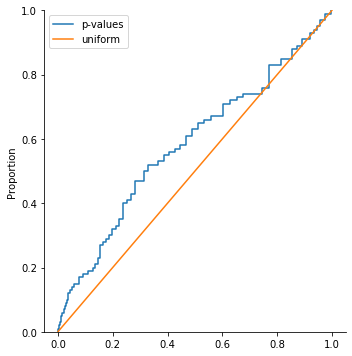

In [105]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Rounded Brunel on [1.0, 2.0] vs. exact brunel on [0.9375, 2.0625]

Get data of second model.

In [106]:
exc_2, inh_2 = exact_equal()
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [107]:
statistics, p_values = ks_test(cv_list_exc_1, cv_list_exc_2)
s = num_fail_pass(p_values)
print(s)

0 tests passed, 100 tests failed.


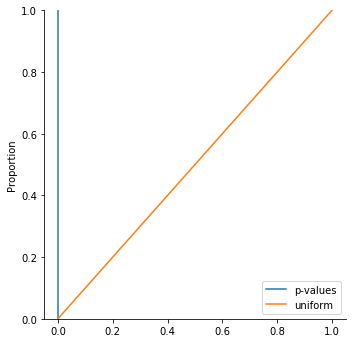

In [108]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [109]:
statistics, p_values = ks_test(cv_list_inh_1, cv_list_inh_2)
s = num_fail_pass(p_values)
print(s)

1 tests passed, 99 tests failed.


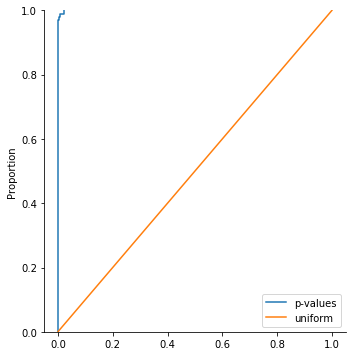

In [110]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Rounded Brunel on [1.0, 2.0] vs. continuous brunel on [1.0, 2.0]
Get data of second model first.

In [111]:
exc_2, inh_2 = continuous()
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [112]:
statistics, p_values = ks_test(cv_list_exc_1, cv_list_exc_2)
s = num_fail_pass(p_values)
print(s)

0 tests passed, 100 tests failed.


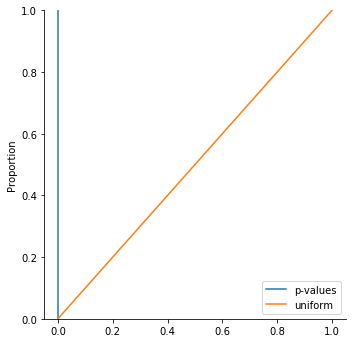

In [113]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [114]:
statistics, p_values = ks_test(cv_list_inh_1, cv_list_inh_2)
s = num_fail_pass(p_values)
print(s)

0 tests passed, 100 tests failed.


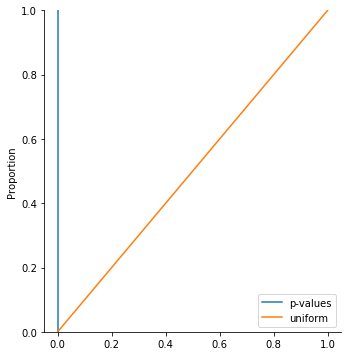

In [115]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Exact brunel on [1.0,2.0] vs. rounded brunel on [0.9375, 2.0625]

Now we can look into the Brunel model with exact spike times and delays from discrete interval [1.0, 2.0]. We have already compared it with the rounded case on the same interval, so skip this one. 

Get the data first.

In [116]:
exc_1, inh_1 = exact_1_2()
cv_list_exc_1, cv_list_inh_1 = get_cv_lists(exc_1, inh_1)

In [117]:
exc_2, inh_2 = round_equal()
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [118]:
statistics, p_values = ks_test(cv_list_exc_1, cv_list_exc_2)
s = num_fail_pass(p_values)
print(s)

0 tests passed, 100 tests failed.


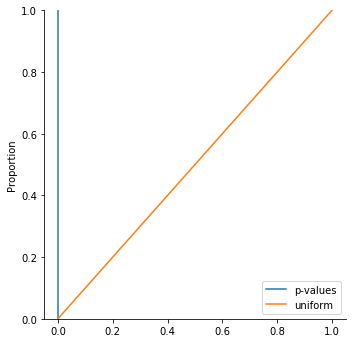

In [119]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [120]:
statistics, p_values = ks_test(cv_list_inh_1, cv_list_inh_2)
s = num_fail_pass(p_values)
print(s)

0 tests passed, 100 tests failed.


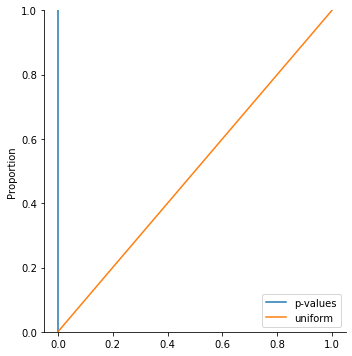

In [121]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Exact brunel [1.0, 2.0] vs. exat brunel [0.9375, 2.0625]

Get the data of the second model.

In [122]:
exc_2, inh_2 = exact_equal()
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [123]:
statistics, p_values = ks_test(cv_list_exc_1, cv_list_exc_2)
s = num_fail_pass(p_values)
print(s)

55 tests passed, 45 tests failed.


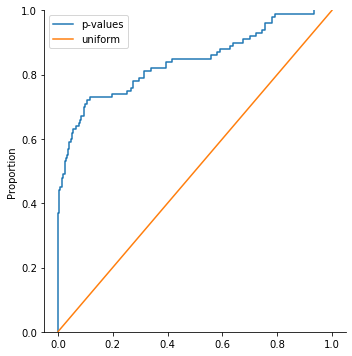

In [124]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [125]:
statistics, p_values = ks_test(cv_list_inh_1, cv_list_inh_2)
s = num_fail_pass(p_values)
print(s)

86 tests passed, 14 tests failed.


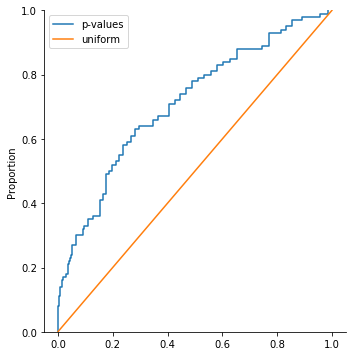

In [126]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Exact brunel [1.0, 2.0] vs. continuous brunel on [10, 2.0]
Get the data of second model.

In [127]:
exc_2, inh_2 = continuous()
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [128]:
statistics, p_values = ks_test(cv_list_exc_1, cv_list_exc_2)
s = num_fail_pass(p_values)
print(s)

77 tests passed, 23 tests failed.


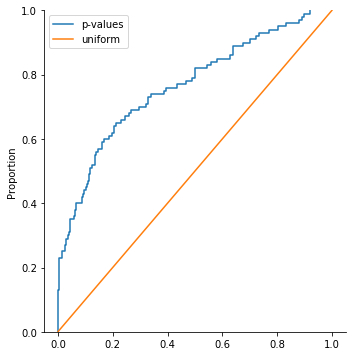

In [129]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [130]:
statistics, p_values = ks_test(cv_list_inh_1, cv_list_inh_2)
s = num_fail_pass(p_values)
print(s)

97 tests passed, 3 tests failed.


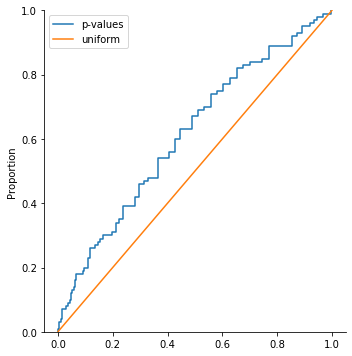

In [131]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Rounded brunel on [0.9375, 2.0625] vs. exact brunel on [0.9375, 2.0625]

We now can compare the rounded brunel on [0.93375, 2.0625] against the other models, it is already tested agains the rounded and exact brunel on [1.0,2.0], only test for the two remaining models. Start with exact brunel on same interval.

In [132]:
exc_1, inh_1 = round_equal()
cv_list_exc_1, cv_list_inh_1 = get_cv_lists(exc_1, inh_1)

In [133]:
exc_2, inh_2 = exact_equal()
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [134]:
statistics, p_values = ks_test(cv_list_exc_1, cv_list_exc_2)
s = num_fail_pass(p_values)
print(s)

0 tests passed, 100 tests failed.


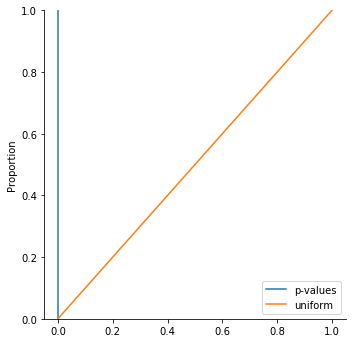

In [135]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [136]:
statistics, p_values = ks_test(cv_list_inh_1, cv_list_inh_2)
s = num_fail_pass(p_values)
print(s)

1 tests passed, 99 tests failed.


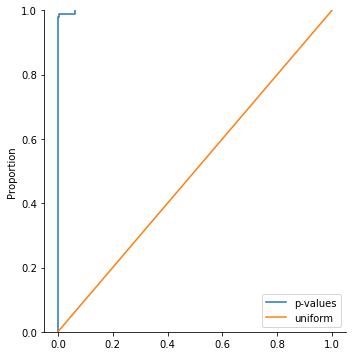

In [137]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Rounded brunel on [0.9375, 2.0625] vs. continuous brunel on [1.0, 2.0]

In [138]:
exc_2, inh_2 = continuous()
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [139]:
statistics, p_values = ks_test(cv_list_exc_1, cv_list_exc_2)
s = num_fail_pass(p_values)
print(s)

0 tests passed, 100 tests failed.


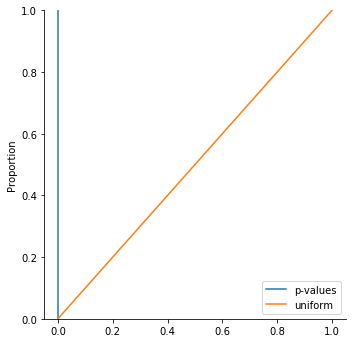

In [140]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [141]:
statistics, p_values = ks_test(cv_list_inh_1, cv_list_inh_2)
s = num_fail_pass(p_values)
print(s)

0 tests passed, 100 tests failed.


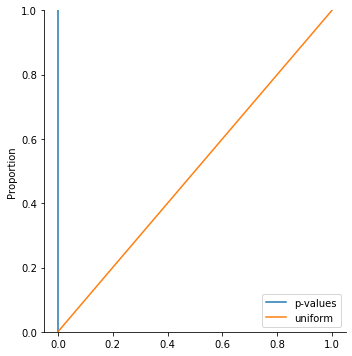

In [142]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

Lastly we have the model with exact spike times on [0.9375, 2.0625], the only model it has not yet been compared to is the continous model, let us compare them here.

### Exact brunel on [0.9375, 2.0625] vs. continuous brunel on [1.0, 2.0]


In [143]:
exc_1, inh_1 = exact_equal()
cv_list_exc_1, cv_list_inh_1 = get_cv_lists(exc_1, inh_1)

In [144]:
exc_2, inh_2 = continuous()
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [145]:
statistics, p_values = ks_test(cv_list_exc_1, cv_list_exc_2)
s = num_fail_pass(p_values)
print(s)

47 tests passed, 53 tests failed.


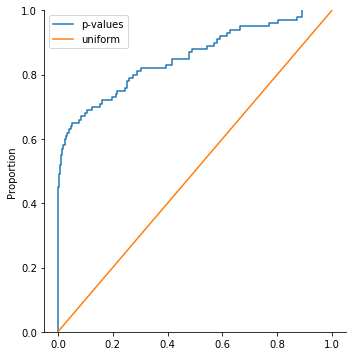

In [146]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [147]:
statistics, p_values = ks_test(cv_list_inh_1, cv_list_inh_2)
s = num_fail_pass(p_values)
print(s)

87 tests passed, 13 tests failed.


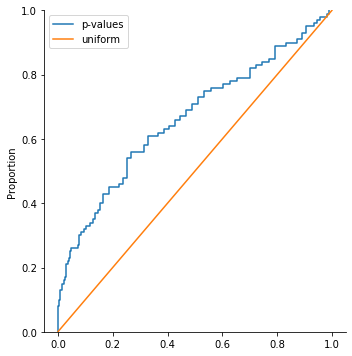

In [148]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()